# Modeling the Fire Data for Fires Over 1 Acre and Lasting Longer than 24 Hours

In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ridge_regression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

In [146]:
df1 = pd.read_csv('../../data/cleaned/bigger_wildfire_weather_extra.csv')
df2 = pd.read_csv('../../data/processed/precipitation_sum_180d.csv')
df3 = pd.read_csv('../../data/cleaned/land_cover.csv', index_col = 'Unnamed: 0')

df2.rename(columns = {'ID': 'id'}, inplace = True)
df3.rename(columns = {'fire_id': 'id'}, inplace = True)

df = pd.merge(df1, df2, on = 'id')
df.head()

,id,x,y,containmentdatetime,controldatetime,dailyacres,discoveryacres,firecause,firediscoverydatetime,incidenttypecategory,...,temp_2m_mean,rain_sum,dew_frost_point_2m,wet_bulb_temp_2m,relative_humidity,clear_sky_photosynthetically_active_radiation,all_sky_photosynthetically_active_radiation,all_sky_surface_uv_index,sum_rain,sum_snow
0,1,-115.748812,40.617506,2020-08-03 23:00:00+00:00,2020-09-02 15:00:00+00:00,5985.90,5.0,Natural,2020-07-19 23:00:00+00:00,WF,...,23.396304,12.62,3.02,13.91,27.31,155.74,135.50,2.55,84.37,1.32
1,5,-113.751212,35.515265,2020-10-17 21:59:59+00:00,2020-10-19 15:00:00+00:00,135.00,1.0,Human,2020-10-15 18:17:00+00:00,WF,...,21.522000,0.00,-6.50,8.11,13.62,97.43,97.50,1.37,10.54,0.00
2,10,-120.073602,39.769989,2020-06-24 19:02:00+00:00,2020-06-25 16:05:59+00:00,132.00,15.0,Natural,2020-06-24 00:17:59+00:00,WF,...,25.600000,0.16,7.16,16.69,33.44,160.50,160.38,2.82,68.55,0.66
3,12,-120.772613,39.361785,2021-01-20 03:29:00+00:00,2021-01-21 00:57:00+00:00,1.88,1.0,Human,2021-01-19 19:40:00+00:00,WF,...,1.500000,0.00,-9.35,-4.95,51.38,59.11,57.91,0.37,700.02,14.17
4,15,-122.974081,41.825916,2020-07-23 17:00:00+00:00,2020-07-26 15:00:00+00:00,13.00,0.1,Human,2020-07-22 19:09:59+00:00,WF,...,21.058000,1.61,8.76,15.53,48.62,142.94,114.08,1.96,295.31,0.66


In [147]:
df3['in_df'] = df3['id'].map(lambda x: True if x in df['id'].unique() else False)
df3 = df3[df3['in_df'] == True].copy()
df3.drop(columns = 'in_df', inplace = True)
df = pd.merge(df, df3, on = 'id')

In [150]:
for i in df.columns:
    print(i)

id
x
y
containmentdatetime
controldatetime
dailyacres
discoveryacres
firecause
firediscoverydatetime
incidenttypecategory
incidenttypekind
initiallatitude
initiallongitude
irwinid
localincidentidentifier
poocounty
poodispatchcenterid
poofips
poostate
uniquefireidentifier
temp_2m
temp_2m_max
humidity
rain
wind_speed_2m
wind_speed_2m_max
wind_speed_10m
wind_speed_10m_max
surface_soil_wetness_5cm_below
surface_soil_wetness_to_bedrock
wind_speed_2m_mean
wind_speed_2m_max_mean
wind_speed_10m_mean
wind_speed_10m_max_mean
humidity_mean
temp_2m_mean
rain_sum
dew_frost_point_2m
wet_bulb_temp_2m
relative_humidity
clear_sky_photosynthetically_active_radiation
all_sky_photosynthetically_active_radiation
all_sky_surface_uv_index
sum_rain
sum_snow
land_cover_class


In [153]:
df_final = df.drop(columns = ['x', 'y', 'containmentdatetime', 'controldatetime', 'firecause', 'firediscoverydatetime', 'incidenttypecategory', 'incidenttypekind', 'initiallatitude', 
                   'initiallongitude', 'irwinid', 'localincidentidentifier', 'poocounty', 'poodispatchcenterid', 'poofips', 'poostate', 'uniquefireidentifier'])

df_final.to_csv('../../data/cleaned/final_all.csv', index = False)

In [106]:
df['firediscoverydatetime'] = pd.to_datetime(df['firediscoverydatetime'])
df['controldatetime'] = pd.to_datetime(df['controldatetime'])
df['containmentdatetime'] = pd.to_datetime(df['containmentdatetime'])

---
######
### Investigating Correlation Between the Features and Target (DailyAcres)
######
___

In [111]:
cols = ['dailyacres', 'discoveryacres', 'temp_2m', 'temp_2m_max', 'humidity', 'rain', 'wind_speed_2m', 'wind_speed_2m_max', 'wind_speed_10m', 
        'wind_speed_10m_max', 'surface_soil_wetness_5cm_below', 'surface_soil_wetness_to_bedrock', 'wind_speed_2m_mean', 'wind_speed_2m_max_mean', 
        'wind_speed_10m_mean', 'wind_speed_10m_max_mean', 'humidity_mean', 'temp_2m_mean', 'rain_sum', 'dew_frost_point_2m', 'wet_bulb_temp_2m', 
        'relative_humidity', 'clear_sky_photosynthetically_active_radiation', 'all_sky_photosynthetically_active_radiation', 'all_sky_surface_uv_index',
        'sum_rain', 'sum_snow','land_cover_class']

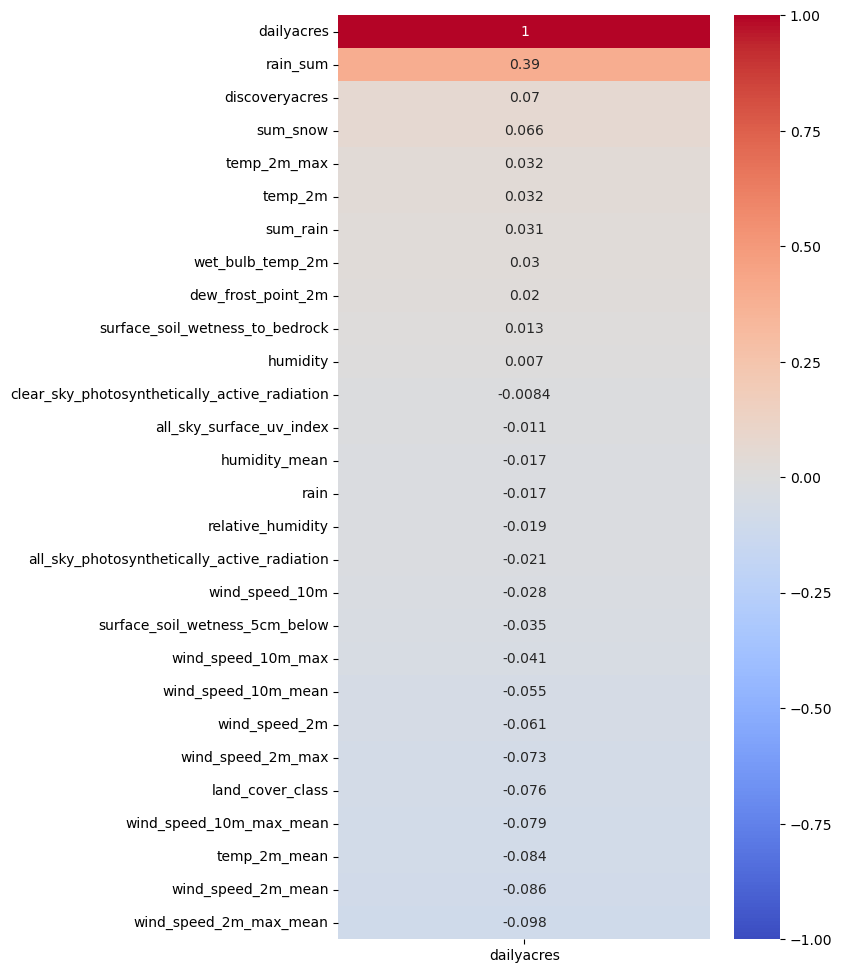

In [112]:
plt.figure(figsize = (6, 12))
sns.heatmap(df[cols].corr()[['dailyacres']].sort_values(by = 'dailyacres', ascending=False),
            vmin = -1,
            vmax = 1, 
            cmap = 'coolwarm',
            annot = True);

---
######
### Train/Test Splitting Data, and Standard Scaling
######
___

In [115]:
df = df[cols]

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'dailyacres'), df['dailyacres'], random_state= 42)

In [116]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

---
######
### Using PCA For Feature Elimination
######
___

In [117]:
pca = PCA(random_state = 42)


Z_train = pca.fit_transform(X_train)
Z_test = pca.transform(X_test)

In [118]:
explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)
np.round(cumulative[:25], 3)

array([0.282, 0.524, 0.633, 0.708, 0.759, 0.796, 0.83 , 0.862, 0.89 ,
       0.917, 0.94 , 0.958, 0.968, 0.975, 0.981, 0.987, 0.991, 0.994,
       0.996, 0.997, 0.998, 0.999, 0.999, 1.   , 1.   ])

In [119]:
Z_train = Z_train[:,:21]
Z_test = Z_test[:,:21]

In [156]:
#np.savetxt('../../data/processed/Neural_Net_Data/X_train_bigfires.csv', X_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/X_test_bigfires.csv', X_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_train_bigfires.csv', Z_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_test_bigfires.csv', Z_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_train_bigfires.csv', y_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_test_bigfires.csv', y_test, delimiter=',')

---
######
### Modeling / Simple Models
######
---

#### Linear Regression (Baseline) with DF

In [122]:
#Linear Regression - Baseline
# With X data
lr = LinearRegression()

lr.fit(X_train, y_train)
print(f'Training R-Squared: {lr.score(X_train, y_train)}')
print(f'Testing R-Squared: {lr.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test), squared = False)}')

Training R-Squared: 0.19739018310920142
Testing R-Squared: 0.19076646029240552
RMSE: 23216.059880963156


#### Linear Regression (Baseline) with PCA

In [123]:
#Linear Regression - Baseline
# With PCA Data
lr = LinearRegression()

lr.fit(Z_train, y_train)
print(f'Training R-Squared: {lr.score(Z_train, y_train)}')
print(f'Testing R-Squared: {lr.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(Z_test), squared = False)}')

Training R-Squared: 0.1933073400115911
Testing R-Squared: 0.19291386451202308
RMSE: 23185.236033384786


In [124]:
def model_eval(model, param_dict, training_data):
    '''
    d
    '''
    
    gs_model = GridSearchCV(model,
                            param_grid = param_dict,
                            n_jobs = -1)
    if training_data == 'X_train':
        gs_model.fit(X_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(X_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(X_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(X_test, y_test)}')
        
    elif training_data == 'Z_train':
        gs_model.fit(Z_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(Z_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(Z_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(Z_test, y_test)}')
    else:
        return 'Try Again'

#### KNN Regression with DF

In [125]:
#KNN Regressor with X Data

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(1000, 2001, 100),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'X_train')

C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-0.01535031 -0.00032509 -0.02404008 -0.00628761 -0.03802579 -0.01389006
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan]
  warnings.warn(


Best Score: -0.01535031277411163
Best Params: {'n_neighbors': 1000, 'weights': 'uniform'}
RMSE: 25698.68923069178
Training R-Squared: 0.006822544554237253
Testing R-Squared: 0.008440479069879214


#### KNN Regression with PCA Data

In [126]:
#KNN Regressor with PCA Data

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(1000, 2001, 100),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'Z_train')

C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-0.01545806 -0.00036381 -0.02411753 -0.00629527 -0.03800726 -0.01386402
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan]
  warnings.warn(


Best Score: -0.015458063753086249
Best Params: {'n_neighbors': 1000, 'weights': 'uniform'}
RMSE: 25698.582263132146
Training R-Squared: 0.006950635532416927
Testing R-Squared: 0.00844873353612774


#### Lasso Regression with DF

In [127]:
# Lasso Regression with X Data

lasso = Lasso()
lasso_params = {
    'alpha': range(5, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'X_train')

Best Score: -0.28651987966936526
Best Params: {'alpha': 99}
RMSE: 23166.4829301105
Training R-Squared: 0.19158723630157604
Testing R-Squared: 0.19421894060407774


#### Lasso Regression with PCA

In [128]:
# Lasso Regression with PCA Data

lasso = Lasso()
lasso_params = {
    'alpha': range(5, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'Z_train')

Best Score: -0.29166245804445756
Best Params: {'alpha': 99}
RMSE: 23197.6605247954
Training R-Squared: 0.190781372738975
Testing R-Squared: 0.19204863100349


#### Adaboost Regression with DF

In [129]:
# Adaboost with X Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.5, 0.75, 1, 1.25, 1.5] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'X_train')

Best Score: -1.8136521296094252
Best Params: {'learning_rate': 0.5, 'n_estimators': 40}
RMSE: 24444.842100875307
Training R-Squared: 0.5388359932261007
Testing R-Squared: 0.10283707854158564


#### Adaboost Regression with PCA

In [130]:
# Adaboost with PCA Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.5, 0.75, 1, 1.25, 1.5] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'Z_train')

Best Score: -2.159768757988474
Best Params: {'learning_rate': 0.5, 'n_estimators': 40}
RMSE: 27109.90735192742
Training R-Squared: 0.3991051014040763
Testing R-Squared: -0.10345063921473652


#### RandomForest Regression with DF

In [131]:
# Random Forest with X_train

rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(70, 201, 10),
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'ccp_alpha': [0.01, 0.1, 0.5, 1]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'X_train')

Best Score: -0.5668645699791524
Best Params: {'ccp_alpha': 0.1, 'max_depth': 110, 'min_samples_leaf': 3, 'min_samples_split': 3}
RMSE: 23527.148757119452
Training R-Squared: 0.5940775627739668
Testing R-Squared: 0.16893414238688165


#### RandomForest Regression with PCA

In [132]:
# Random Forest with PCA

rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(70, 201, 10),
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'ccp_alpha': [0.01, 0.1, 0.5, 1]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'Z_train')

Best Score: -0.6028585729361743
Best Params: {'ccp_alpha': 0.01, 'max_depth': 130, 'min_samples_leaf': 3, 'min_samples_split': 2}
RMSE: 21649.87961329207
Training R-Squared: 0.5973968996479067
Testing R-Squared: 0.29626716440503464


---
######
### Modeling / Ensemble Models
######
---

#### Stacking Regression with DF and with DecisionTreeRegressor Final Estimator

In [133]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: -1.0519899969591835
Testing R-Squared: 0.48127114500659085
RMSE: 18587.534239480887


#### Stacking Regression with PCA and with DecisionTreeRegressor Final Estimator

In [134]:
# Stacking Regressor with Z_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: -1.376835972762767
Testing R-Squared: -0.721945152010171
RMSE: 33865.791879141056


#### Stacking Regression with DF and with LinearRegression Final Estimator

In [135]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.14633600665832736
Testing R-Squared: 0.19244589650306565
RMSE: 23191.956738869027


#### Stacking Regression with PCA and with LinearRegression Final Estimator

In [136]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.233480129444812
Testing R-Squared: 0.20341129288866233
RMSE: 23033.962250152916


#### Stacking Regression with DF and with Lasso Final Estimator

In [137]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.175241847820651
Testing R-Squared: 0.19394875508836518
RMSE: 23170.366567891117


#### Stacking Regression with PCA and with Lasso Final Estimator

In [138]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.19332944794583917
Testing R-Squared: 0.20715643724763977
RMSE: 22979.751623060085


#### Stacking Regression (different base estimators) with DF and with Lasso Final Estimator

In [139]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.16211171101661137
Testing R-Squared: 0.19119512665893712
RMSE: 23209.910072639253


#### Stacking Regression (different base estimators) with PCA and with Lasso Final Estimator

In [140]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: -0.03768155290684905
Testing R-Squared: 0.19023266444347553
RMSE: 23223.715639663038


#### Voting Regression with DF

In [141]:
#Voting Classifier with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(X_train, y_train)
print(f'Training R-Squared: {vote.score(X_train, y_train)}')
print(f'Testing R-Squared: {vote.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(X_test), squared = False)}')

Training R-Squared: 0.706705411692887
Testing R-Squared: 0.1615309753005223
RMSE: 23631.70680116012


#### Voting Regression with PCA

In [142]:
#Voting Classifier with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(Z_train, y_train)
print(f'Training R-Squared: {vote.score(Z_train, y_train)}')
print(f'Testing R-Squared: {vote.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(Z_test), squared = False)}')

Training R-Squared: 0.6515036228752032
Testing R-Squared: 0.2222934116557822
RMSE: 22759.329695758766
